<a href="https://colab.research.google.com/github/AtfastrSlushyMaker/pl-standings-prediction-project/blob/main/notebooks/data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import Libraries and Configuration

In [25]:
# Imports
import pandas as pd              # Data manipulation
import numpy as np               # Numerical operations
import matplotlib.pyplot as plt  # Basic plots
import seaborn as sns            # Advanced plots
from pathlib import Path         # File paths
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Display options for quick inspection
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)

In [26]:
# Preprocessing strategy aligned to model family
# Options: 'tree' (DecisionTree/RandomForest/GBM) or 'linear' (LogReg/SVM/KNN)
MODEL_FAMILY = 'tree'  # change to 'linear' if needed

# Encoding strategy derived from model family
# - tree: label-encode nominal categories to avoid large one-hot expansions (trees handle splits)
# - linear: one-hot to avoid fake ordinality
ENCODING_STRATEGY = 'label' if MODEL_FAMILY == 'tree' else 'onehot'

# Scaling: trees don't need scaling; linear models usually benefit from z-scoring
APPLY_SCALING = (MODEL_FAMILY != 'tree')

print(f"MODEL_FAMILY={MODEL_FAMILY} | ENCODING_STRATEGY={ENCODING_STRATEGY} | APPLY_SCALING={APPLY_SCALING}")

MODEL_FAMILY=tree | ENCODING_STRATEGY=label | APPLY_SCALING=False


## 2. Load Dataset

In [27]:
# 1) Load data
candidate_paths = [
    Path('data/raw/combined/premier_league_combined.csv'),
    Path('../data/raw/combined/premier_league_combined.csv'),
    Path('../../data/raw/combined/premier_league_combined.csv'),
    Path('premier_league_combined.csv')
]

csv_path = next((p for p in candidate_paths if p.exists()), None)
if csv_path is None:
    raise FileNotFoundError('premier_league_combined.csv not found in expected locations. '
                            'Checked: ' + ', '.join(str(p) for p in candidate_paths))

print(f'Reading: {csv_path}')
df = pd.read_csv(csv_path)
print(df.shape)
df.head()

Reading: premier_league_combined.csv
(12324, 24)


,Season,SourceFile,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,1993-94,season-9394.csv,1993-08-14,Arsenal,Coventry,0,3,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-94,season-9394.csv,1993-08-14,Aston Villa,QPR,4,1,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-94,season-9394.csv,1993-08-14,Chelsea,Blackburn,1,2,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-94,season-9394.csv,1993-08-14,Liverpool,Sheffield Weds,2,0,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-94,season-9394.csv,1993-08-14,Man City,Leeds,1,1,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Filter Complete Seasons

In [28]:
# 2) Keep only complete seasons (simple, conservative rule)
performance_features = ['HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']

seasons_with_missing = df.loc[df[performance_features].isnull().any(axis=1), 'Season'].unique()
print("Seasons containing missing performance features:", seasons_with_missing)

# Keep seasons with full performance data
initial_shape = df.shape
df = df[~df['Season'].isin(seasons_with_missing)].reset_index(drop=True)
print(f"Removed {len(seasons_with_missing)} incomplete seasons. {initial_shape} -> {df.shape}")

Seasons containing missing performance features: ['1993-94' '1994-95' '1995-96' '1996-97' '1997-98' '1998-99' '1999-00']
Removed 7 incomplete seasons. (12324, 24) -> (9500, 24)


## 4. Data Quality Check

In [29]:
# 3) Quick data overview
print("Remaining missing values per column:")
print(df.isnull().sum())

print("\nSample of team names (Home/Away):")
print(sorted(df['HomeTeam'].unique())[:20])
print(sorted(df['AwayTeam'].unique())[:20])

Remaining missing values per column:
Season        0
SourceFile    0
Date          0
HomeTeam      0
AwayTeam      0
FTHG          0
FTAG          0
FTR           0
HTHG          0
HTAG          0
HTR           0
Referee       0
HS            0
AS            0
HST           0
AST           0
HF            0
AF            0
HC            0
AC            0
HY            0
AY            0
HR            0
AR            0
dtype: int64

Sample of team names (Home/Away):
['Arsenal', 'Aston Villa', 'Birmingham', 'Blackburn', 'Blackpool', 'Bolton', 'Bournemouth', 'Bradford', 'Brentford', 'Brighton', 'Burnley', 'Cardiff', 'Charlton', 'Chelsea', 'Coventry', 'Crystal Palace', 'Derby', 'Everton', 'Fulham', 'Huddersfield']
['Arsenal', 'Aston Villa', 'Birmingham', 'Blackburn', 'Blackpool', 'Bolton', 'Bournemouth', 'Bradford', 'Brentford', 'Brighton', 'Burnley', 'Cardiff', 'Charlton', 'Chelsea', 'Coventry', 'Crystal Palace', 'Derby', 'Everton', 'Fulham', 'Huddersfield']


## 5. Correlation Matrix of Numeric Features

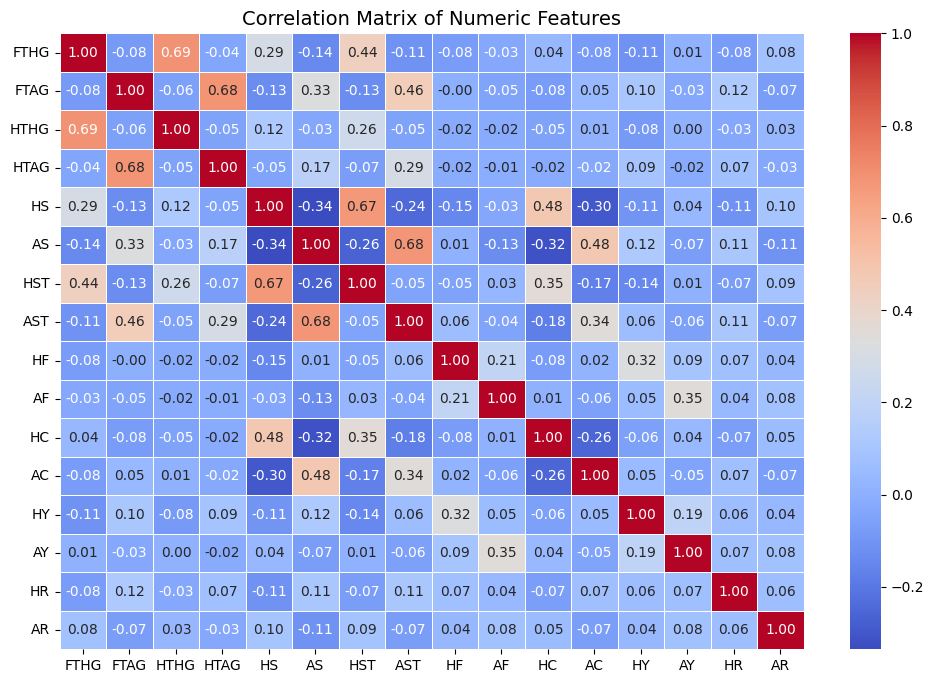

In [30]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features", fontsize=14)
plt.show()

## 6. Remove Unused Columns

In [32]:
# 5) Drop non-relevant columns used only for description
cols_to_drop = ['HTHG', 'HTAG', 'HTR', 'Referee', 'SourceFile']
existing = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=existing)
print("Dropped columns:", existing)
print("New dataset shape:", df.shape)
df.head()

Dropped columns: ['HTHG', 'HTAG', 'HTR', 'Referee', 'SourceFile']
New dataset shape: (9500, 19)


,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,2000-01,2000-08-19,Charlton,Man City,4,0,H,17.0,8.0,14.0,4.0,13.0,12.0,6.0,6.0,1.0,2.0,0.0,0.0
1,2000-01,2000-08-19,Chelsea,West Ham,4,2,H,17.0,12.0,10.0,5.0,19.0,14.0,7.0,7.0,1.0,2.0,0.0,0.0
2,2000-01,2000-08-19,Coventry,Middlesbrough,1,3,A,6.0,16.0,3.0,9.0,15.0,21.0,8.0,4.0,5.0,3.0,1.0,0.0
3,2000-01,2000-08-19,Derby,Southampton,2,2,D,6.0,13.0,4.0,6.0,11.0,13.0,5.0,8.0,1.0,1.0,0.0,0.0
4,2000-01,2000-08-19,Leeds,Everton,2,0,H,17.0,12.0,8.0,6.0,21.0,20.0,6.0,4.0,1.0,3.0,0.0,0.0


## 7. Encode Categorical Variables

In [33]:
# Encode categorical variables
# Target encoding: FTR (Full Time Result)
if 'FTR' in df.columns:
    ftr_encoder = LabelEncoder()
    df['FTR_encoded'] = ftr_encoder.fit_transform(df['FTR'])
    print("Encoded FTR -> FTR_encoded. Classes:", list(ftr_encoder.classes_))
    # Keep original FTR for reference

# Season encoding (optional)
if 'Season' in df.columns:
    season_encoder = LabelEncoder()
    df['Season_encoded'] = season_encoder.fit_transform(df['Season'])
    # Keep original Season for reference

team_cols = ['HomeTeam','AwayTeam']
existing_team_cols = [c for c in team_cols if c in df.columns]

if ENCODING_STRATEGY == 'onehot':
    # One-hot encoding for linear models
    df = pd.get_dummies(df, columns=existing_team_cols, drop_first=True, prefix=['Home', 'Away'])
    print("One-hot encoding completed. New shape:", df.shape)
elif ENCODING_STRATEGY == 'label':
    # Label-encode team names for tree models to reduce dimensionality
    for col in existing_team_cols:
        le = LabelEncoder()
        df[col + '_le'] = le.fit_transform(df[col])
    # Keep original team names for reference/visualization
    print("Label encoding completed for:", existing_team_cols)
    print("Original team names preserved for reference.")
else:
    raise ValueError("Unknown ENCODING_STRATEGY. Use 'onehot' or 'label'.")

Encoded FTR -> FTR_encoded. Classes: ['A', 'D', 'H']
Label encoding completed for: ['HomeTeam', 'AwayTeam']
Original team names preserved for reference.


## 8. Standardize Numeric Features (Optional)

In [34]:
# 8) Standardize numeric features (z-score) only when helpful
numeric_features = ['FTHG','FTAG','HS','AS','HST','AST','HF','AF','HC','AC',
                    'HY','AY','HR','AR','GoalDiff','TotalGoals','ShotAcc_H','ShotAcc_A']
numeric_features = [c for c in numeric_features if c in df.columns]

if APPLY_SCALING and numeric_features:
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df[numeric_features]),
        columns=[c + '_z' for c in numeric_features],
        index=df.index,
    )
    df = pd.concat([df.drop(columns=numeric_features), df_scaled], axis=1)
    print("Standardization applied. Dataset ready for linear models.")
else:
    print("Standardization skipped for tree-based models or no numeric features found.")

df.head()

Standardization skipped for tree-based models or no numeric features found.


,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,FTR_encoded,Season_encoded,HomeTeam_le,AwayTeam_le
0,2000-01,2000-08-19,Charlton,Man City,4,0,H,17.0,8.0,14.0,4.0,13.0,12.0,6.0,6.0,1.0,2.0,0.0,0.0,2,0,12,26
1,2000-01,2000-08-19,Chelsea,West Ham,4,2,H,17.0,12.0,10.0,5.0,19.0,14.0,7.0,7.0,1.0,2.0,0.0,0.0,2,0,13,43
2,2000-01,2000-08-19,Coventry,Middlesbrough,1,3,A,6.0,16.0,3.0,9.0,15.0,21.0,8.0,4.0,5.0,3.0,1.0,0.0,0,0,14,28
3,2000-01,2000-08-19,Derby,Southampton,2,2,D,6.0,13.0,4.0,6.0,11.0,13.0,5.0,8.0,1.0,1.0,0.0,0.0,1,0,16,36
4,2000-01,2000-08-19,Leeds,Everton,2,0,H,17.0,12.0,8.0,6.0,21.0,20.0,6.0,4.0,1.0,3.0,0.0,0.0,2,0,22,17


In [35]:
# Save processed data
SAVE_PROCESSED = True

if SAVE_PROCESSED:
    output_dir = Path('../data/processed')
    output_dir.mkdir(parents=True, exist_ok=True)

    # Save the full processed dataframe
    # Contains both original columns (for reference/display) and encoded columns (for modeling)
    output_path = output_dir / 'processed_premier_league_combined.csv'
    df.to_csv(output_path, index=False)

    print(f"✅ Saved processed data to {output_path}")
    print(f"📊 Shape: {df.shape}")
    print(f"\n📋 Columns included:")
    print(f"   - Original: Season, Date, HomeTeam, AwayTeam, FTR")
    print(f"   - Encoded: Season_encoded, HomeTeam_le, AwayTeam_le, FTR_encoded")
    print(f"   - Match stats: FTHG, FTAG, HS, AS, HST, AST, HF, AF, HC, AC, HY, AY, HR, AR")
    print(f"\n💡 Use original columns for display/interpretation")
    print(f"💡 Use encoded columns for model training")
else:
    print("Set SAVE_PROCESSED=True to save processed dataframe.")

✅ Saved processed data to ../data/processed/processed_premier_league_combined.csv
📊 Shape: (9500, 23)

📋 Columns included:
   - Original: Season, Date, HomeTeam, AwayTeam, FTR
   - Encoded: Season_encoded, HomeTeam_le, AwayTeam_le, FTR_encoded
   - Match stats: FTHG, FTAG, HS, AS, HST, AST, HF, AF, HC, AC, HY, AY, HR, AR

💡 Use original columns for display/interpretation
💡 Use encoded columns for model training


## Summary

This notebook prepared the Premier League match data for machine learning:

1. **📥 Loaded** the combined CSV dataset
2. **🔍 Filtered** to keep only complete seasons (no missing performance stats)
3. **✅ Checked** data quality (missing values, team names)
4. **🗑️ Removed** unused columns (half-time stats, referee, source files)
5. **🔢 Encoded** categorical variables:
   - FTR → FTR_encoded (target: 0=Away, 1=Draw, 2=Home)
   - Season → Season_encoded
   - Teams → HomeTeam_le, AwayTeam_le (for tree models)
   - **Original columns preserved** for reference and display
6. **📊 Standardized** numeric features (only for linear models; skipped for trees)
7. **💾 Saved** processed data with both original and encoded columns

**🎯 Next steps:**
- Load the processed data in your modeling notebook
- Split features (X) and target (y) during model training phase
- Use encoded columns for training, original columns for interpretation

## 8. Save Processed Data